In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

### 定义内容损失函数 Content Cost

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [2]:
# Computes the layer content cost
def compute_layer_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    J_content_layer = tf.reduce_sum((a_C - a_G)**2)/(4*n_H*n_W*n_C)
    
    return J_content_layer

In [3]:
# Computes the overall content cost from several chosen layers
def compute_content_cost(model, CONTENT_LAYERS):
    # initialize the overall content cost
    J_content = 0
    
    for layer_name, coeff in CONTENT_LAYERS:
        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_C to be the hidden layer activation from the layer we have selected
        a_C = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out

        # Compute the content cost
        J_content_layer = compute_layer_content_cost(a_C, a_G)
        
        # Add coeff * J_content_layer of this layer to overall content cost
        J_content += coeff * J_content_layer
    
    return J_content

### 定义风格损失函数 Style Cost

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [4]:
# Computes the layer style cost
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_S = tf.reshape(a_S, [n_H*n_W, n_C])
    a_G = tf.reshape(a_G, [n_H*n_W, n_C])

    GS = tf.transpose(a_S) @ a_S
    GG = tf.transpose(a_G) @ a_G

    J_style_layer = tf.reduce_sum((GS - GG)**2)/((2*n_H*n_W*n_C)**2)
    
    return J_style_layer

In [5]:
# Computes the overall style cost from several chosen layers
def compute_style_cost(model, STYLE_LAYERS):
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### 参数设定

In [6]:
class CONFIG:
    IMAGE_WIDTH = 300
    IMAGE_HEIGHT = 225
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'

### 载入内容图片和风格图片

In [7]:
# Reshape and normalize the input image (content or style)
def reshape_and_normalize_image(image):
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image

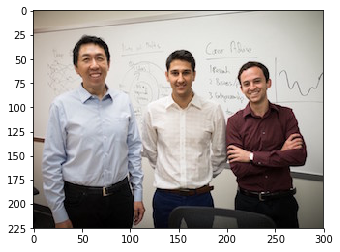

In [8]:
content_image = scipy.misc.imread(CONFIG.CONTENT_IMAGE)
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

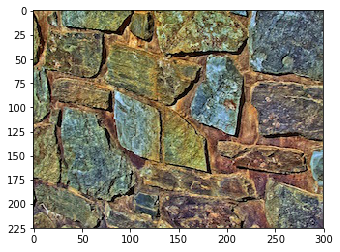

In [9]:
style_image = scipy.misc.imread(CONFIG.STYLE_IMAGE)
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

### 生成随机初始图片

In [10]:
# Generates a noisy image by adding random noise to the content_image
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [11]:
def unnormalize_image(image):
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    
    return image

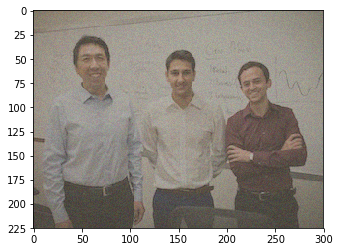

In [12]:
input_image = generate_noise_image(content_image)
imshow(unnormalize_image(input_image))

### 载入VGG19模型

In [13]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [14]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [15]:
model = load_vgg_model(CONFIG.VGG_MODEL)

In [16]:
model.keys()

dict_keys(['input', 'conv1_1', 'conv1_2', 'avgpool1', 'conv2_1', 'conv2_2', 'avgpool2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4', 'avgpool3', 'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'avgpool4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4', 'avgpool5'])

### 训练神经风格转换模型

In [17]:
CONTENT_LAYERS = [('conv4_2', 1.0)]

In [18]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [19]:
def model_nn(sess, input_image, content_image, style_image, alpha = 10, beta = 40, num_iterations = 200):
    # Assign the content image to be the input of the VGG model.  
    sess.run(model['input'].assign(content_image))

    # Compute the content cost
    J_content = compute_content_cost(model, CONTENT_LAYERS)
    
    # Assign the input of the model to be the "style" image 
    sess.run(model['input'].assign(style_image))

    # Compute the style cost
    J_style = compute_style_cost(model, STYLE_LAYERS)
    
    # Compute the total cost J
    J = alpha * J_content + beta * J_style
    
    # define optimizer
    optimizer = tf.train.AdamOptimizer(2.0)

    # define train_step
    train_step = optimizer.minimize(J)
    
    # Initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))
    
    peroid = 20
    col = 5
    row = 1 + np.ceil(num_iterations / peroid / col)
    plt.figure(figsize=(20, 3 * row))
    
    for i in range(num_iterations):
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%peroid == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            print("====================")
            
            plt.subplot(row, col, 1 + i // peroid)
            plt.imshow(unnormalize_image(generated_image), interpolation='nearest')
            plt.axis('off')
            plt.title("iteration %d" % i, fontweight='bold')
    
    # Draw last generated image
    plt.subplot(row, col, 1 + col * (row - 1))
    plt.imshow(unnormalize_image(generated_image), interpolation='nearest')
    plt.axis('off')
    plt.title("output", fontweight='bold')
    
    return generated_image

Iteration 0 :
total cost = 3440429600.0
content cost = 12258.7295
style cost = 86007670.0
Iteration 20 :
total cost = 239176750.0
content cost = 18890.795
style cost = 5974696.0
Iteration 40 :
total cost = 91218540.0
content cost = 20348.773
style cost = 2275376.5
Iteration 60 :
total cost = 50575944.0
content cost = 21139.285
style cost = 1259113.8
Iteration 80 :
total cost = 34330684.0
content cost = 21587.596
style cost = 852870.25
Iteration 100 :
total cost = 26334028.0
content cost = 21861.01
style cost = 652885.44
Iteration 120 :
total cost = 21802954.0
content cost = 22078.441
style cost = 539554.25
Iteration 140 :
total cost = 18851802.0
content cost = 22265.78
style cost = 465728.62
Iteration 160 :
total cost = 16728591.0
content cost = 22432.691
style cost = 412606.6
Iteration 180 :
total cost = 15088357.0
content cost = 22578.086
style cost = 371564.4


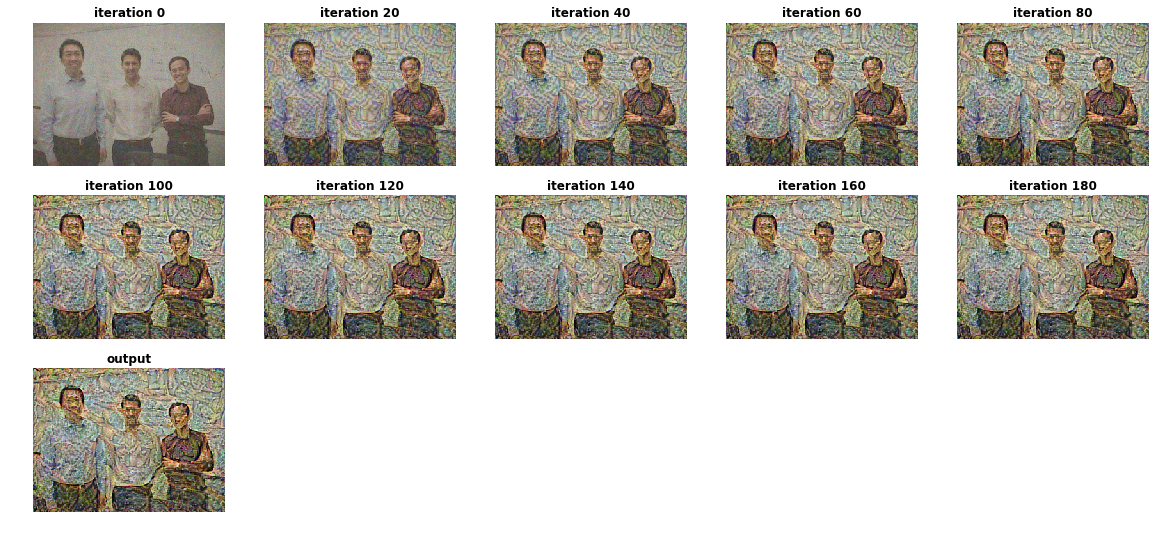

In [20]:
generated_image = model_nn(sess, input_image, content_image, style_image, num_iterations = 200)